In [1]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# --- Configuration ---
dataset_dir = './archive'  # Dataset path
output_dir = './sea animals'    # Where to save the split dataset
split_ratio = [0.75, 0.1, 0.15]   # Train, Val, Test split
random.seed(42)

# --- Create output folders ---
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):  # Ensure it's a folder
            os.makedirs(os.path.join(output_dir, split, class_name), exist_ok=True)

# --- Process each class folder ---
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not images:
        continue

    # Split into train, val, and test
    train_imgs, temp_imgs = train_test_split(images, test_size=(1 - split_ratio[0]), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=split_ratio[2]/(split_ratio[1] + split_ratio[2]), random_state=42)

    # Copy files to respective folders
    for img_name in train_imgs:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(output_dir, 'train', class_name, img_name))
    for img_name in val_imgs:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(output_dir, 'val', class_name, img_name))
    for img_name in test_imgs:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(output_dir, 'test', class_name, img_name))

print("Dataset split completed successfully!")

Dataset split completed successfully!


In [ ]:
import tensorflow as tf
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint

INPUT_SIZE = (300, 300)

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    "sea animals/train",
    shuffle=True,
    image_size=INPUT_SIZE,
    label_mode='int'  # labels as indices
)
# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    "sea animals/val",
    shuffle=False,
    image_size=INPUT_SIZE,
    label_mode='int'
)
# Load test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    "sea animals/test",
    shuffle=False,
    image_size=INPUT_SIZE,
    label_mode='int'
)

Found 10273 files belonging to 23 classes.


Found 1369 files belonging to 23 classes.
Found 2068 files belonging to 23 classes.


In [2]:
preprocess = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

In [3]:
base_model = tf.keras.applications.EfficientNetB3(
weights='imagenet',
include_top=False,
input_shape=(INPUT_SIZE[0], INPUT_SIZE[1], 3)
)
for layer in base_model.layers[:len(base_model.layers)-4]:
    layer.trainable = False

In [8]:
inputs = base_model.input
x = preprocess(inputs)
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(23, activation='softmax')(x)

model = models.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # SparseCategoricalAccuracy

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 10,883,398 (41.52 MB)

 Trainable params: 692,759 (2.64 MB)

 Non-trainable params: 10,190,639 (38.87 MB)

In [ ]:
checkpoint_path = "./checkpoints/efficientnetb3_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 3,
                               restore_best_weights = True)

In [11]:
history = model.fit(
train_ds,
validation_data=val_ds,
epochs=10,
callbacks=[
    early_stopping,
    checkpoint_callback
]
)

Epoch 1/10


322/322 ━━━━━━━━━━━━━━━━━━━━ 147s 323ms/step - accuracy: 0.7234 - loss: 1.0241 - val_accuracy: 0.8510 - val_loss: 0.5053
Epoch 2/10


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 183ms/step - accuracy: 0.8646 - loss: 0.4429 - val_accuracy: 0.8707 - val_loss: 0.4499
Epoch 3/10


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 183ms/step - accuracy: 0.9013 - loss: 0.3362 - val_accuracy: 0.8758 - val_loss: 0.4479
Epoch 4/10


322/322 ━━━━━━━━━━━━━━━━━━━━ 58s 181ms/step - accuracy: 0.9187 - loss: 0.2826 - val_accuracy: 0.8685 - val_loss: 0.4734
Epoch 5/10


322/322 ━━━━━━━━━━━━━━━━━━━━ 58s 181ms/step - accuracy: 0.9265 - loss: 0.2445 - val_accuracy: 0.8663 - val_loss: 0.4920
Epoch 6/10


322/322 ━━━━━━━━━━━━━━━━━━━━ 59s 183ms/step - accuracy: 0.9399 - loss: 0.1831 - val_accuracy: 0.8766 - val_loss: 0.5066


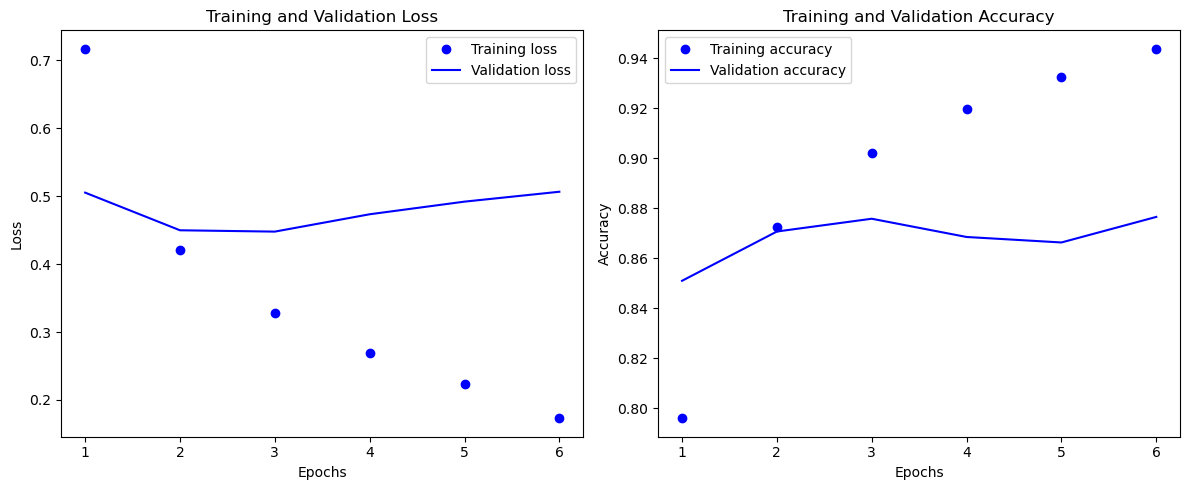

In [12]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values)+1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss
ax1.plot(epochs, loss_values, 'bo', label='Training loss')
ax1.plot(epochs, val_loss_values, 'b', label='Validation loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot Accuracy
ax2.plot(epochs, acc_values, 'bo', label='Training accuracy')
ax2.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [13]:
loss, accuracy = model.evaluate(test_ds)

print("Loss:", loss)
print("Accuracy:", accuracy)

65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 334ms/step - accuracy: 0.8360 - loss: 0.6193
Loss: 0.45107558369636536
Accuracy: 0.8742746710777283


In [ ]:
import numpy as np
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    return cam_path

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (INPUT_SIZE[0], INPUT_SIZE[1], 3)
# Remove last layer's softmax
model.layers[-1].activation = None

In [ ]:
import pandas as pd
import os

# Path to your dataset
test_dir = "sea animals/test"

# Get class names (these will be used as labels)
class_names = test_ds.class_names

# Initialize lists to store the image data, labels, and file paths
images = []
image_paths = []

# Function to load image paths and corresponding labels
def load_image_paths_and_labels(directory):
    image_paths = []
    labels = []
    
    # Iterate through the directory structure to gather file paths and labels
    class_names = os.listdir(directory)
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust image types if necessary
                    image_paths.append(os.path.join(class_path, filename))
                    labels.append(class_name)  # Append the class name instead of index
    
    return image_paths, labels

# Get image paths and labels
image_paths, labels = load_image_paths_and_labels(test_dir)

# Iterate through the dataset to extract image data
for image_batch, _ in test_ds:
    images.append(image_batch.numpy())

# Flatten the images and convert to a single array
images = np.vstack(images).reshape(-1, np.prod(INPUT_SIZE) * 3)  # Flatten to 1D for each image

# Create a DataFrame with images, class names as labels, and file paths
test_df = pd.DataFrame(images)
test_df['label'] = labels
test_df['filepath'] = image_paths

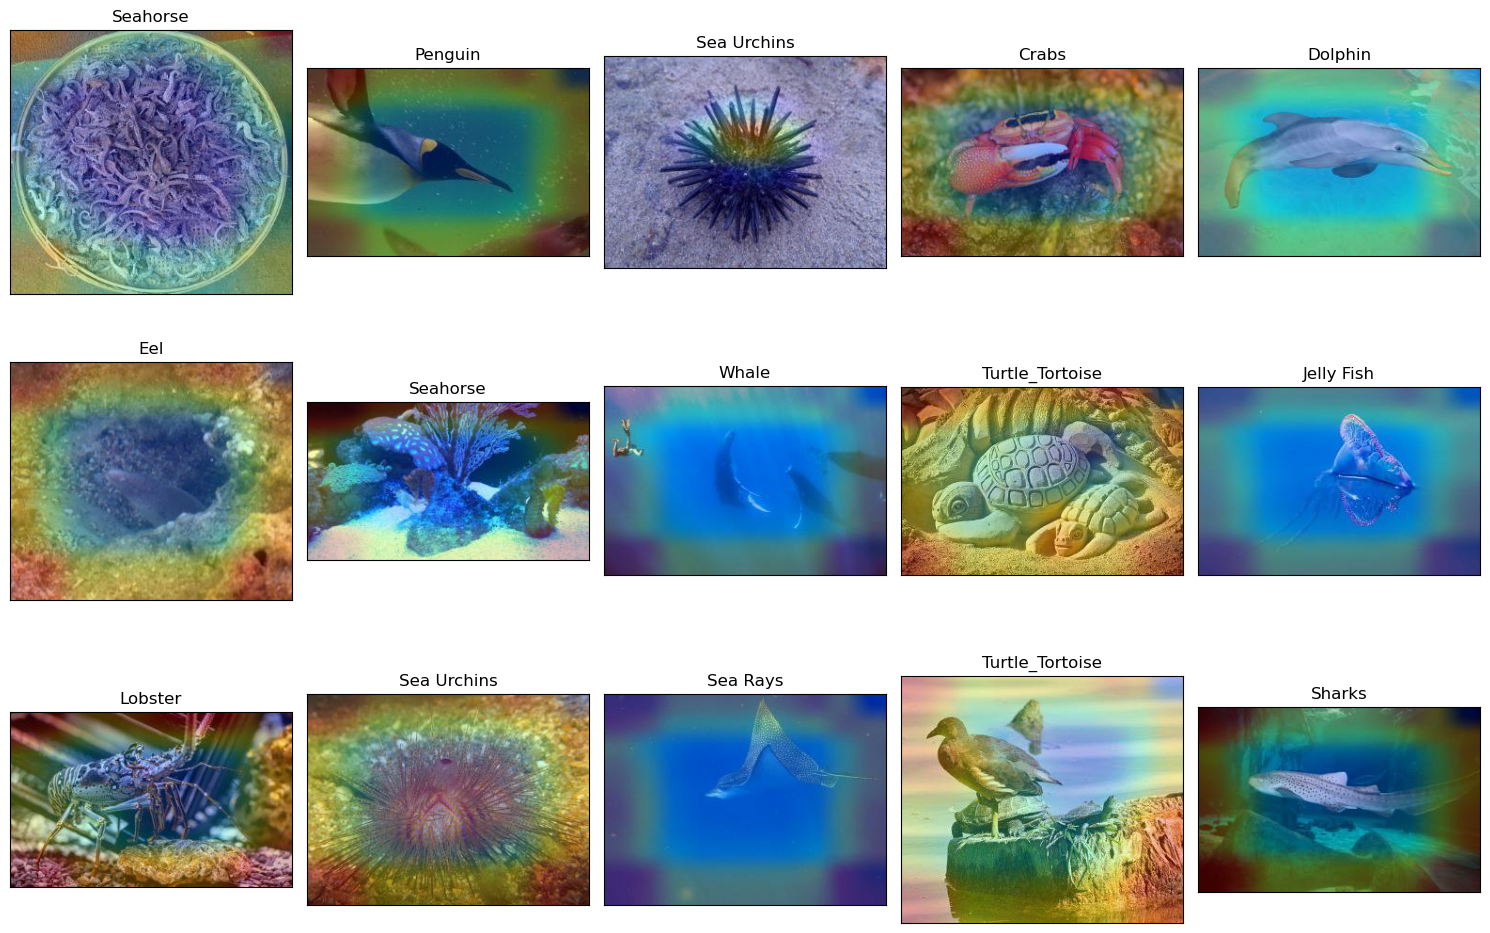

In [ ]:
random_index = np.random.randint(0, len(test_df), 16)
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df['filepath'].iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(test_df['label'].iloc[random_index[i]])
plt.tight_layout()
plt.show()

os.remove("cam.jpg")